# Importance Sampling

Below, we will exemplify the use of self-normalised importance sampling (SNIS) to estimate the expected value of a function $f$ with respect to a probability distribution $p$. Note that SNIS is the general form as pointed out in the lecture and we will not provide simple examples involving normalised distributions. You are encouraged to extend this .ipynb file to include such examples.

In this example, we will consider a numerically challenging density to integrate, which is widely used in research papers. This is also called the banana density, which is defined as follows:
\begin{align*}
\pi(x) \propto \exp\left(- \frac{x_1^2}{10} - \frac{x_2^2}{10} - 2 (x_2 - x_1^2)^2)
\right).
\end{align*}
In what follows, we will show two things

- How to estimate expectations with respect to $p$ using SNIS.
- How to use this in the setting of Bayesian inference using resampling ideas.

First, let us visualise our density.

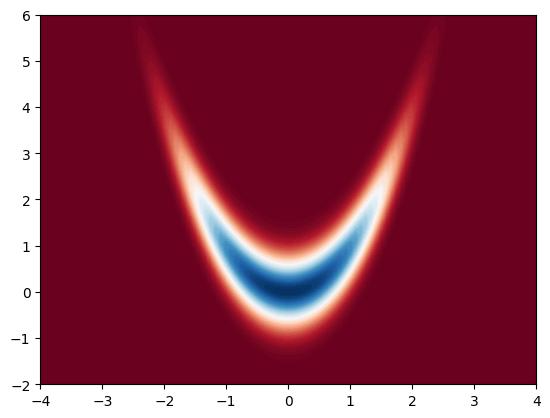

In [21]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(26)

def bar_p(x): # implementing the density just for visualisation!
    return np.exp(-x[0]**2/10 - x[1]**2/10 - 2 * (x[1] - x[0]**2)**2)

def logbar_p(x):
    return - x[0]**2/10 - x[1]**2/10 - 2 * (x[1] - x[0]**2)**2

# we implement the log-density as we will only use log-density for the computations
# due to stability issues

x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-2, 6, 100)
X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
Z_bb = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        Z_bb[i, j] = bar_p([X_bb[i, j], Y_bb[i, j]])
plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
plt.show()

This is the density we would like to integrate. Let us now estimate its mean using a Gaussian propsoal. We will center the Gaussian around $m = (0, 0)$ to cover our target density properly.

In [22]:
sig_     = 5 # standard deviation of the proposal

def logq(x, sig): # log-density of the proposal
    return - x[0]**2/(2 * sig**2) - x[1]**2/(2 * sig**2) - np.log(2 * np.pi * sig**2)

def phi(x):
    return np.mean(x, axis=0)

# Self-normalised importance sampling
def SNIS_banana(N, sig):
    x_samples = rng.normal(0, sig, (N, 2)) # N 2D samples from the proposal
    logw = np.zeros(N) # log-weights
    for i in range(N):
        logw[i] = logbar_p(x_samples[i, :]) - logq(x_samples[i, :], sig)
    logw = logw - np.max(logw) # to avoid numerical issues (look up this trick)
    w = np.exp(logw)/np.sum(np.exp(logw)) # normalising the weights
    return phi(x_samples)

N = 100000
phi_SNIS = SNIS_banana(N, sig_  )
print(phi_SNIS)

[0.00613798 0.0063439 ]


Of course at this stage $\varphi(x)$ above (`phi(x)`) can be changed with any test function. This essentially estimates $(\varphi, \pi)$.

Let us use $\pi(x)$ as described above now as a prior in a Bayesian setting. We will need a likelihood which we simply take as
\begin{align*}
p(y|x) = \mathcal{N}(y; H x, \sigma^2 I),
\end{align*}
where $H = [1, 0]$. This likelihood ``observes'' the first dimension of the state $x$. We will use the same proposal as before, i.e. $\mathcal{N}(x; 0, \sigma_0^2 I)$.

We will be now interested in estimating quantities w.r.t.
\begin{align*}
\pi(x|y) \propto p(y|x) \pi(x).
\end{align*}
Let us now set $\sigma = 0.01$ and $y = 1$. In other words, we have observed $y$ with a very small variance.

In [23]:
def loglik(y, x, sig):
    H = [1, 0]
    return -(y - H @ x)**2/(2 * sig**2) - np.log(sig * np.sqrt(2 * np.pi))

def ESS(w): # To measure sample quality
    return 1/np.sum(w**2)

sig = 0.01 # standard deviation of the likelihood
y = 1 # observation

sig_q = 1 # standard deviation of the proposal

N = 10000
# sample from q
x = rng.normal(0, 1, (2, N)) # 2 x N matrix (2 dimensional, N samples)

# compute logW
logW = np.zeros(N)
for i in range(N):
    logW[i] = (loglik(y, x[:, i], sig)) + logbar_p(x[:, i]) - logq(x[:, i], sig_q)

logW = logW - np.max(logW)
w = np.exp(logW)/np.sum(np.exp(logW))

mean = np.sum(w * x, axis=1)

print(mean)
print("ESS: ", ESS(w))

[0.9990529  0.97190592]
ESS:  30.777859151970176


Note that now the samples we obtained are attached to weights, that are, we have $\{\mathsf{w}_i, X_i\}_{i=1}^N$. We cannot now directly plot the histogram of the samples, as without the weights, they would be just the samples from the proposal.

A common trick to get back samples that are approximately distributed w.r.t. target is to resample the samples with replacement according to the weights. This is also at the heart of the bootstrap particle filter which we will cover later.

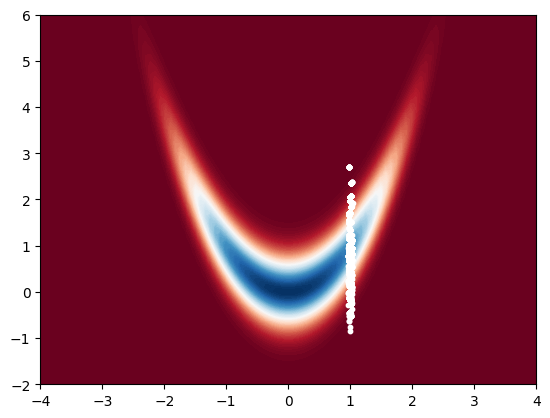

In [24]:
# resample N samples
x_resampled = np.zeros((2, N))
for i in range(N):
    x_resampled[:, i] = x[:, rng.choice(N, p=w)]
    # rng.choice chooses an index from 0 to N-1 with probability w

# now we resampled N samples from this sample set, they are equally weighted so we can plot them
# plotting them will give us an approximation of the posterior

# plot resampled samples
x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-2, 6, 100)
X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
Z_bb = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        Z_bb[i, j] = bar_p([X_bb[i, j], Y_bb[i, j]])
plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
plt.scatter(x_resampled[0, :], x_resampled[1, :], s=10, c='white')
plt.show()